
# Import packages

In [1]:
import sys
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as st
import random
import matplotlib.pyplot as plt

sys.path.append('../../')
from utils import dataframe_utils

In [2]:
satellite_ttherm_ids = list((pd.read_csv('./selected-annotation-data.tsv', delimiter='\t'))['TTHERM_ID'].values)

In [3]:
len(satellite_ttherm_ids)

604

# Import the data for each timepoint

In [4]:
# file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_*'))
file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_*'))
file_paths

['./rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_000min_A',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_000min_B',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_030min_A',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_030min_B',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_060min_A',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_060min_B',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_090min_A',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_090min_B',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_120min_A',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_120min_B',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_150min_A',
 './rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_150

In [5]:
dict_tpms = {}

for fp in file_paths:
    split = ((os.path.splitext(os.path.basename(fp))[0]).split('_'))
    key = '_'.join(split[len(split)-2:len(split)])
    print(key)
    dict_tpms[key] = (pd.read_csv(os.path.join(fp, 'abundance.tsv'), delimiter='\t'))

print(np.unique([df.shape for df in dict_tpms.values()]))

000min_A
000min_B
030min_A
030min_B
060min_A
060min_B
090min_A
090min_B
120min_A
120min_B
150min_A
150min_B
180min_A
180min_B
210min_A
210min_B
240min_A
240min_B
[    5 26749]


In [6]:
dict_tpms['000min_A'].head()

,target_id,length,eff_length,est_counts,tpm
0,YF00013476.t1,7372,7181.76,757.0,2.008530
1,YF00013477.t1,3083,2892.76,289.0,1.903700
2,YF00036563.t1,5153,4962.76,14.0,0.053755
3,YF00013481.t1,1236,1045.76,6540.0,119.168000
4,YF00013482.t1,1679,1488.76,2154.0,27.569900


In [7]:
def computeRPK(row):
    if not row['eff_length'] > 0:
        print('ZERO sequence length:', row['target_id'])
        print(row)
        return 'ZERO sequence length'
    return row['est_counts']/row['eff_length']

def computeTPM(row, normalization_factor):
    return row['rpk']/normalization_factor

def compute_tpm_columns(df_dict):
    df_tpm = {}
    normalization_factor_dict = {}
    for key, df in df_dict.items():
        tpm_df = df
        tpm_df['rpk'] = tpm_df.apply(computeRPK, axis=1)
        tpm_df = tpm_df.loc[tpm_df['rpk']!='ZERO sequence length']

        sum_rpk = tpm_df['rpk'].sum()

        normalization_factor = sum_rpk/1_000_000

        tpm_df['tpm_manual'] = tpm_df.apply(computeTPM, axis=1, args=(normalization_factor,))

        df_tpm[key] = tpm_df  
        normalization_factor_dict[key] = normalization_factor

    return df_tpm, normalization_factor_dict

def compute_cpm_columns(df_dict):
    df_cpm = {}
    for key, df in df_dict.items():
        cpm_df = df

        sum_count = cpm_df['est_counts'].sum()

        cpm_df['cpm_manual'] = (cpm_df['est_counts'] / sum_count) * 1_000_000

        df_cpm[key] = cpm_df  

    return df_cpm

In [8]:
dict_tpms, norm_factors_dict = compute_tpm_columns(dict_tpms)

In [9]:
dict_tpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual
0,YF00013476.t1,7372,7184.29,764.0,2.31391,0.106343,2.313916
1,YF00013477.t1,3083,2895.29,2783.0,20.91510,0.961216,20.915065
2,YF00036563.t1,5153,4965.29,699.0,3.06317,0.140777,3.063167
3,YF00013481.t1,1236,1048.29,2769.0,57.47530,2.641445,57.475082
4,YF00013482.t1,1679,1491.29,4641.0,67.71550,3.112071,67.715416


In [10]:
dict_cpms = compute_cpm_columns(dict_tpms)

In [11]:
dict_cpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,YF00013476.t1,7372,7184.29,764.0,2.31391,0.106343,2.313916,15.891086
1,YF00013477.t1,3083,2895.29,2783.0,20.91510,0.961216,20.915065,57.885985
2,YF00036563.t1,5153,4965.29,699.0,3.06317,0.140777,3.063167,14.539096
3,YF00013481.t1,1236,1048.29,2769.0,57.47530,2.641445,57.475082,57.594787
4,YF00013482.t1,1679,1491.29,4641.0,67.71550,3.112071,67.715416,96.532108


In [12]:
norm_factors_dict

{'000min_A': 0.052479155446462464,
 '000min_B': 0.055318333427186714,
 '030min_A': 0.05440679555315988,
 '030min_B': 0.04974538009575775,
 '060min_A': 0.0515436123794466,
 '060min_B': 0.06020259699425683,
 '090min_A': 0.04722185068863247,
 '090min_B': 0.05155870735137967,
 '120min_A': 0.047831178786496835,
 '120min_B': 0.056323027105710494,
 '150min_A': 0.045958083780551995,
 '150min_B': 0.05194959443283497,
 '180min_A': 0.05506078775487389,
 '180min_B': 0.052749417324184714,
 '210min_A': 0.04213322695630423,
 '210min_B': 0.051830673761785885,
 '240min_A': 0.05942148943422184,
 '240min_B': 0.05521629467969519}

In [13]:
ttherm_id = 'YF00013476.t1'

dict_tpms['000min_A'].loc[dict_tpms['000min_A']['target_id'] == ttherm_id]

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,YF00013476.t1,7372,7181.76,757.0,2.00853,0.105406,2.008529,13.862679


In [14]:
dict_tpms['000min_A'].shape

(26749, 8)

## Checkout a single timepoint

In [15]:
num_nonzero = (dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0].shape)[0]

mean = dict_tpms['000min_A']['tpm'].mean()

std = dict_tpms['000min_A']['tpm'].std()

str_summary_wzeros = f'''WITH ZEROS...
MEAN: {mean}
MEDIAN: {dict_tpms['000min_A']['tpm'].median()}
STDEV: {std}
CV: {(std/mean)*100}
MAX: {dict_tpms['000min_A']['tpm'].max()}
MIN: {dict_tpms['000min_A']['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

df_tpm_wozeros = dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0]

mean_wozeros = df_tpm_wozeros['tpm'].mean()

std_wozeros = df_tpm_wozeros['tpm'].std()

str_summary_wozeros = f'''WITHOUT ZEROS...
MEAN: {mean_wozeros}
MEDIAN: {df_tpm_wozeros['tpm'].median()}
STDEV: {std_wozeros}
CV: {(std_wozeros/mean_wozeros)*100}
MAX: {df_tpm_wozeros['tpm'].max()}
MIN: {df_tpm_wozeros['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

print(str_summary_wzeros, '\n', str_summary_wozeros, sep='')


WITH ZEROS...
MEAN: 37.38457465959441
MEDIAN: 1.20753
STDEV: 292.9820601056942
CV: 783.697722318483
MAX: 13954.1
MIN: 0.0
# GENES EXPRESSED: 23428

WITHOUT ZEROS...
MEAN: 42.68396737107269
MEDIAN: 1.87083
STDEV: 312.6990575084484
CV: 732.5913610372763
MAX: 13954.1
MIN: 1.74197e-09
# GENES EXPRESSED: 23428



# Create a dataframe containing all data at every timepoint (sorted by TTHERM_ID)

In [16]:
column_prefixes = sorted(list(dict_tpms.keys()))
column_prefixes

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [17]:
complete_data_df = None

for col_prefix in column_prefixes:
    curr_df = dict_tpms[col_prefix].sort_values(by='target_id')
    curr_df.rename(columns={col: (f'{col_prefix}_{col}') for col in list(curr_df.columns) if col != 'target_id'}, inplace=True)

    if complete_data_df is None:
        complete_data_df = curr_df
        continue

    complete_data_df = dataframe_utils.sql_query_df({'complete_data_df': complete_data_df, 'curr_df': curr_df},
                                                    '''SELECT * FROM complete_data_df
                                                       INNER JOIN curr_df USING(target_id)'''
                                                    )

complete_data_df.rename(columns={'target_id': 'TTHERM_ID'}, inplace=True)
complete_data_df


,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_rpk,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual
0,YF00000001.t1,606,415.957,12.000,0.549725,0.028849,0.549726,0.219752,606,417.858,...,0.026715,0.449587,0.182584,606,414.352,22.000,0.961581,0.053095,0.961581,0.394285
1,YF00000003.t1,4533,4342.760,11088.000,48.652000,2.553215,48.651984,203.050704,4533,4344.720,...,3.514834,59.150883,253.111400,4533,4341.220,16561.000,69.088800,3.814826,69.088777,296.806826
2,YF00000004.t1,1460,1269.760,102.000,1.530710,0.080330,1.530706,1.867891,1460,1271.720,...,1.122113,18.883955,23.569951,1460,1268.220,1264.000,18.050300,0.996673,18.050333,22.653453
3,YF00000005.t1,834,643.756,907.000,26.847200,1.408919,26.847210,16.609577,834,645.724,...,2.336189,39.315561,24.798245,834,642.219,1900.000,53.580100,2.958492,53.580059,34.051867
4,YF00000006.t1,1247,1056.760,1321.000,23.819900,1.250047,23.819882,24.191015,1247,1058.720,...,1.606697,27.038983,28.068160,1247,1055.220,1695.000,29.091100,1.606300,29.091052,30.377850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26744,YF00038377.t1,2389,2198.760,117.992,1.022560,0.053663,1.022558,2.160747,2389,2200.720,...,0.099207,1.669541,3.613606,2389,2197.220,154.408,1.272710,0.070274,1.272709,2.767306
26745,YF00038378.t1,4357,4166.760,105.000,0.480180,0.025199,0.480180,1.922829,4357,4168.720,...,0.003363,0.056602,0.232380,4357,4165.220,17.000,0.073917,0.004081,0.073917,0.304675
26746,YF00038379.t1,1050,859.756,101.614,2.252110,0.118189,2.252120,1.860822,1050,861.724,...,0.148897,2.505782,2.114274,1050,858.219,165.190,3.485930,0.192480,3.485928,2.960541
26747,YF00038708.t1,1705,1514.760,378.000,4.755120,0.249544,4.755116,6.922183,1705,1516.720,...,0.007945,0.133698,0.199183,1705,1513.220,18.000,0.215429,0.011895,0.215429,0.322597


# SATELLITE GENE COUNTS

In [18]:
(complete_data_df[['TTHERM_ID'] + [col for col in complete_data_df if 'counts' in col]].loc[complete_data_df['TTHERM_ID'].isin(satellite_ttherm_ids)])

,TTHERM_ID,000min_A_est_counts,000min_B_est_counts,030min_A_est_counts,030min_B_est_counts,060min_A_est_counts,060min_B_est_counts,090min_A_est_counts,090min_B_est_counts,120min_A_est_counts,120min_B_est_counts,150min_A_est_counts,150min_B_est_counts,180min_A_est_counts,180min_B_est_counts,210min_A_est_counts,210min_B_est_counts,240min_A_est_counts,240min_B_est_counts
68,YF00000081.t1,17.8047,91.6045,35.552,97.9211,32.6155,94.8016,26.7063,159.309,17.8196,145.540,20.7933,207.939,44.4276,94.2787,26.6214,41.0642,53.3219,106.762
169,YF00000208.t1,0.0000,2.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
181,YF00000224.t1,0.0000,1.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,1.0000,0.000
217,YF00000266.t1,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,1.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
293,YF00000364.t1,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,1.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26561,YF00038078.t1,1.0000,1.0000,0.000,0.0000,1.0000,0.0000,0.0000,0.000,1.0000,1.000,0.0000,3.000,1.0000,1.0000,0.0000,0.0000,0.0000,0.000
26607,YF00038144.t1,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,1.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
26621,YF00038176.t1,9.0000,7.0000,15.000,2.0000,6.0000,5.0000,1.0000,2.000,2.0000,11.000,4.0000,9.000,7.0000,4.0000,8.0000,6.0000,2.0000,5.000
26665,YF00038260.t1,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000


In [19]:
# 10 reads cuttoff
complete_data_df['max_count'] = complete_data_df[[col for col in complete_data_df if 'counts' in col]].apply(lambda x: max(x), axis=1)

In [20]:
complete_data_df_filtered = complete_data_df.loc[complete_data_df['max_count'] > 10]
complete_data_df_filtered

,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual,max_count
0,YF00000001.t1,606,415.957,12.000,0.549725,0.028849,0.549726,0.219752,606,417.858,...,0.449587,0.182584,606,414.352,22.000,0.961581,0.053095,0.961581,0.394285,45.000
1,YF00000003.t1,4533,4342.760,11088.000,48.652000,2.553215,48.651984,203.050704,4533,4344.720,...,59.150883,253.111400,4533,4341.220,16561.000,69.088800,3.814826,69.088777,296.806826,19654.000
2,YF00000004.t1,1460,1269.760,102.000,1.530710,0.080330,1.530706,1.867891,1460,1271.720,...,18.883955,23.569951,1460,1268.220,1264.000,18.050300,0.996673,18.050333,22.653453,3813.000
3,YF00000005.t1,834,643.756,907.000,26.847200,1.408919,26.847210,16.609577,834,645.724,...,39.315561,24.798245,834,642.219,1900.000,53.580100,2.958492,53.580059,34.051867,3729.000
4,YF00000006.t1,1247,1056.760,1321.000,23.819900,1.250047,23.819882,24.191015,1247,1058.720,...,27.038983,28.068160,1247,1055.220,1695.000,29.091100,1.606300,29.091052,30.377850,2075.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26742,YF00038375.t1,3203,3012.760,884.000,5.591150,0.293419,5.591147,16.188386,3203,3014.720,...,4.072322,12.083750,3203,3011.220,802.000,4.823530,0.266337,4.823526,14.373472,1036.000
26744,YF00038377.t1,2389,2198.760,117.992,1.022560,0.053663,1.022558,2.160747,2389,2200.720,...,1.669541,3.613606,2389,2197.220,154.408,1.272710,0.070274,1.272709,2.767306,347.233
26745,YF00038378.t1,4357,4166.760,105.000,0.480180,0.025199,0.480180,1.922829,4357,4168.720,...,0.056602,0.232380,4357,4165.220,17.000,0.073917,0.004081,0.073917,0.304675,105.000
26746,YF00038379.t1,1050,859.756,101.614,2.252110,0.118189,2.252120,1.860822,1050,861.724,...,2.505782,2.114274,1050,858.219,165.190,3.485930,0.192480,3.485928,2.960541,470.683


# SATELLITE GENE COUNTS AFTER FILTERING

In [21]:
(complete_data_df_filtered[['TTHERM_ID'] + [col for col in complete_data_df_filtered if 'counts' in col]].loc[complete_data_df_filtered['TTHERM_ID'].isin(satellite_ttherm_ids)])

,TTHERM_ID,000min_A_est_counts,000min_B_est_counts,030min_A_est_counts,030min_B_est_counts,060min_A_est_counts,060min_B_est_counts,090min_A_est_counts,090min_B_est_counts,120min_A_est_counts,120min_B_est_counts,150min_A_est_counts,150min_B_est_counts,180min_A_est_counts,180min_B_est_counts,210min_A_est_counts,210min_B_est_counts,240min_A_est_counts,240min_B_est_counts
68,YF00000081.t1,17.80470,91.6045,35.5520,97.92110,32.61550,94.8016,26.70630,159.3090,17.81960,145.540,20.79330,207.93900,44.42760,94.27870,26.62140,41.06420,53.32190,106.762
558,YF00000703.t1,5.65648,12.0000,6.0000,9.73782,5.14175,14.7471,5.53256,5.6178,3.00000,9.000,3.65504,8.29631,2.00000,6.00000,7.00000,9.84228,7.69036,6.000
2641,YF00003345.t1,4.00000,10.0000,4.0000,6.00000,5.00000,6.0000,1.00000,11.0000,1.00000,9.000,3.00000,6.00000,0.00000,1.00000,1.00000,1.00000,0.00000,4.000
2847,YF00003605.t1,3.06252,24.0000,15.3111,21.18810,13.13050,31.0983,11.00000,42.5774,10.08560,25.269,13.00000,30.11030,9.09031,8.09577,4.19854,8.05535,8.09728,17.000
3435,YF00004364.t1,2635.63000,5729.6600,2746.0700,4989.97000,3593.52000,6967.6700,4007.06000,6318.6800,4026.41000,7466.520,3047.81000,7086.03000,2974.99000,4846.79000,2256.06000,3284.95000,3198.96000,3352.420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26445,YF00037875.t1,1.00000,5.0000,2.0000,4.00000,1.00000,5.0000,0.00000,8.0000,6.00000,5.000,2.00000,13.00000,1.00000,1.00000,0.00000,3.00000,1.00000,5.000
26483,YF00037943.t1,7.00000,8.0000,3.0000,4.00000,4.00000,2.0000,5.00000,5.0000,5.44089,5.000,6.00000,3.00000,10.55640,3.00000,6.00000,2.00000,4.00000,5.000
26546,YF00038060.t1,15658.00000,15932.0000,14616.0000,14733.00000,12868.00000,17293.0000,9932.00000,13492.0000,9552.00000,14111.000,8273.00000,11779.00000,8943.00000,11574.00000,7491.00000,11128.00000,11369.00000,12138.000
26621,YF00038176.t1,9.00000,7.0000,15.0000,2.00000,6.00000,5.0000,1.00000,2.0000,2.00000,11.000,4.00000,9.00000,7.00000,4.00000,8.00000,6.00000,2.00000,5.000


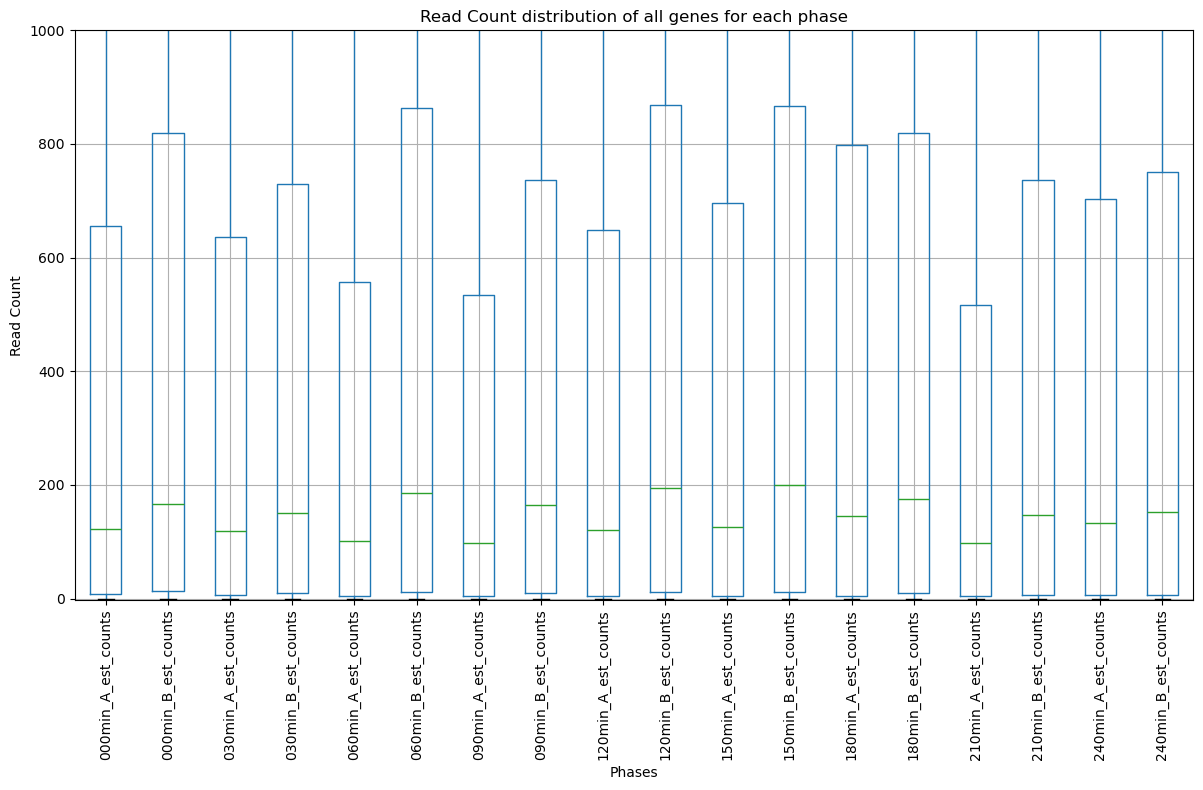

In [22]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

df_data = complete_data_df.loc[:, [col for col in complete_data_df if 'counts' in col]]

# Plot boxplot for each phase
plt.figure(figsize=(12, 8))
df_data.boxplot(rot=90)
plt.title('Read Count distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Read Count')
plt.tight_layout()
plt.ylim(top=1000)
plt.ylim(bottom=-2.5)
plt.show()

# Create a dataframe containing all TPM data at every timepoint (sorted by TTHERM_ID)

In [23]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [24]:
curr_df = dict_tpms['000min_A'].sort_values(by='target_id')
dict_df_all_tpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_tpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_tpm[col] = (curr_df)['tpm'].values

df_all_tpm = pd.DataFrame(dict_df_all_tpm)

print(df_all_tpm.shape)

df_all_tpm.head()

           target_id  length  eff_length  est_counts        tpm       rpk  \
20982  YF00000001.t1     606     415.957        12.0   0.549725  0.028849   
20983  YF00000003.t1    4533    4342.760     11088.0  48.652000  2.553215   
20984  YF00000004.t1    1460    1269.760       102.0   1.530710  0.080330   

       tpm_manual  cpm_manual  
20982    0.549726    0.219752  
20983   48.651984  203.050704  
20984    1.530706    1.867891  
           target_id  length  eff_length  est_counts        tpm       rpk  \
20982  YF00000001.t1     606     415.957        12.0   0.549725  0.028849   
20983  YF00000003.t1    4533    4342.760     11088.0  48.652000  2.553215   
20984  YF00000004.t1    1460    1269.760       102.0   1.530710  0.080330   

       tpm_manual  cpm_manual  
20982    0.549726    0.219752  
20983   48.651984  203.050704  
20984    1.530706    1.867891  
           target_id  length  eff_length  est_counts       tpm       rpk  \
20982  YF00000001.t1     606     417.858        40

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,1.91038,0.519876,1.51815,0.662072,1.88687,0.23247,1.04077,0.449587,0.961581
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,66.35580,74.721600,63.78140,81.596900,72.29420,73.30320,78.97700,59.150900,69.088800
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,36.15000,19.308400,26.61180,15.117300,23.07880,12.54630,21.06410,18.884000,18.050300
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,92.39390,42.991100,111.05500,43.879800,74.51840,43.93570,54.11840,39.315500,53.580100
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,27.22590,32.557700,23.67660,35.820900,28.25220,32.40640,30.07440,27.039000,29.091100


In [25]:
all_cols = list(df_all_tpm.columns)
all_cols

['TTHERM_ID',
 '000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [26]:
tpm_cols = [col for col in df_all_tpm.columns[1:] if 'diff' not in col]
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

# Create a dataframe containing all CPM data at every timepoint (sorted by TTHERM_ID)

In [27]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [28]:
curr_df = dict_cpms['000min_A'].sort_values(by='target_id')
dict_df_all_cpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_cpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_cpm[col] = (curr_df)['cpm_manual'].values

df_all_cpm = pd.DataFrame(dict_df_all_cpm)

print(df_all_cpm.shape)

df_all_cpm.head()

           target_id  length  eff_length  est_counts        tpm       rpk  \
20982  YF00000001.t1     606     415.957        12.0   0.549725  0.028849   
20983  YF00000003.t1    4533    4342.760     11088.0  48.652000  2.553215   
20984  YF00000004.t1    1460    1269.760       102.0   1.530710  0.080330   

       tpm_manual  cpm_manual  
20982    0.549726    0.219752  
20983   48.651984  203.050704  
20984    1.530706    1.867891  
           target_id  length  eff_length  est_counts        tpm       rpk  \
20982  YF00000001.t1     606     415.957        12.0   0.549725  0.028849   
20983  YF00000003.t1    4533    4342.760     11088.0  48.652000  2.553215   
20984  YF00000004.t1    1460    1269.760       102.0   1.530710  0.080330   

       tpm_manual  cpm_manual  
20982    0.549726    0.219752  
20983   48.651984  203.050704  
20984    1.530706    1.867891  
           target_id  length  eff_length  est_counts       tpm       rpk  \
20982  YF00000001.t1     606     417.858        40

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.219752,0.767502,0.358375,0.631572,0.154785,0.618620,0.256215,0.703623,0.454427,0.841828,0.207999,0.676880,0.260106,0.784984,0.092027,0.415975,0.182584,0.394285
1,YF00000003.t1,203.050704,263.272285,299.672847,231.344931,337.083903,249.144783,419.637841,252.745679,366.598672,303.787525,310.375375,295.324714,337.965028,316.788981,308.014471,335.464910,253.111400,296.806826
2,YF00000004.t1,1.867891,5.238199,41.266836,51.388932,73.774591,38.248390,70.587295,50.371160,41.373515,48.451856,23.483032,36.079745,18.259475,29.503918,15.345507,26.036252,23.569951,22.653453
3,YF00000005.t1,16.609577,58.387695,30.533517,58.399385,34.691278,62.462944,33.350682,58.338661,30.756447,62.893876,26.561410,76.487419,26.773628,48.152078,27.078954,33.693973,24.798245,34.051867
4,YF00000006.t1,24.191015,17.901978,21.126183,24.757634,36.393917,25.151321,36.638778,25.723645,35.383340,30.380623,32.967764,26.726497,35.981397,30.040004,32.945677,30.895596,28.068160,30.377850


# Jaccard filtering: https://academic.oup.com/bioinformatics/article/29/17/2146/240530#SEC2.2

In [29]:
cols_a = [col for col in df_all_cpm if 'A' in col]
cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

In [30]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union

In [31]:
np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), 14)

0.017922035253180736

In [32]:
percentiles = np.arange(14, 31, 0.1)

tpm_cutoffs = []

jaccard_similarity_means = []

for _percentile in percentiles:

    tpm_cutoff = np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), _percentile)

    tpm_cutoffs.append(tpm_cutoff)

    jaccard_similarities = []

    for col_a in cols_a:
        col_b = col_a.replace('A', 'B')

        jaccard_similarities.append(jaccard_similarity(set(df_all_cpm.loc[df_all_cpm[col_a] > tpm_cutoff, 'TTHERM_ID'].values), 
                                                        set(df_all_cpm.loc[df_all_cpm[col_b] > tpm_cutoff, 'TTHERM_ID'].values)))

    jaccard_similarity_means.append(np.mean(jaccard_similarities))


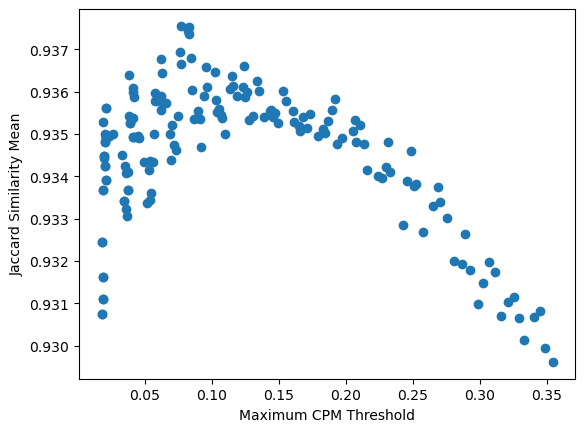

In [33]:
plt.scatter(x=tpm_cutoffs, y=jaccard_similarity_means)
plt.xlabel('Maximum CPM Threshold')
plt.ylabel('Jaccard Similarity Mean')
plt.show()

In [34]:
print(np.argmax(jaccard_similarity_means))
print(jaccard_similarity_means[np.argmax(jaccard_similarity_means)])
print(tpm_cutoffs[np.argmax(jaccard_similarity_means)])

76
0.9375510269642017
0.07675017411163125


In [35]:
CPM_THRESHOLD = tpm_cutoffs[np.argmax(jaccard_similarity_means)]

In [36]:
df_all_cpm['max_cpm'] = df_all_cpm[tpm_cols].apply(lambda x: max(x), axis=1)

In [37]:
df_all_cpm_filtered = df_all_cpm.loc[df_all_cpm['max_cpm'] > CPM_THRESHOLD]
df_all_cpm_filtered.shape, df_all_cpm.shape

((23096, 20), (26749, 20))

In [38]:
((df_all_cpm_filtered[['TTHERM_ID'] + tpm_cols].loc[df_all_cpm_filtered['TTHERM_ID'].isin(satellite_ttherm_ids)])).shape

(111, 19)

# Translate to TTHERM_ID

In [39]:
df_y_to_ttherm = pd.read_csv('../tgd2024/yf_ttherm_mapping_feb2024.csv')
dict_y_to_ttherm = {yf: ttherm for yf, ttherm in zip(df_y_to_ttherm['yf2024'].values, df_y_to_ttherm['ttherm2021'].values)}

In [40]:
dict_y_to_ttherm

{'YF00003507.t1': 'TTHERM_00655860',
 'YF00028628.t1': 'TTHERM_00927120',
 'YF00019461.t1': 'TTHERM_00716070',
 'YF00018024.t1': 'TTHERM_00188330',
 'YF00011744.t1': 'TTHERM_00264990',
 'YF00000692.t1': 'TTHERM_00301690',
 'YF00020018.t1': 'TTHERM_00571650',
 'YF00027771.t1': 'TTHERM_001414123',
 'YF00005353.t1': 'TTHERM_00146080',
 'YF00007877.t1': 'TTHERM_000672289',
 'YF00013833.t1': 'TTHERM_00335730',
 'YF00009042.t1': 'TTHERM_00427470',
 'YF00015223.t1': 'TTHERM_00170160',
 'YF00000272.t1': 'TTHERM_00155480',
 'YF00015664.t1': 'TTHERM_00660400',
 'YF00005973.t1': 'TTHERM_00522430',
 'YF00028690.t1': 'TTHERM_00945200',
 'YF00001875.t1': 'TTHERM_000492719',
 'YF00004732.t1': 'TTHERM_00467760',
 'YF00018327.t1': 'TTHERM_00823880',
 'YF00001113.t1': 'TTHERM_00217210',
 'YF00016026.t1': 'TTHERM_00225760',
 'YF00013217.t1': 'TTHERM_00134890',
 'YF00009571.t1': 'TTHERM_00709740',
 'YF00004778.t1': 'TTHERM_00467320',
 'YF00001824.t1': 'TTHERM_00492320',
 'YF00025848.t1': 'TTHERM_00979890'

In [41]:
# df_all_tpm['TTHERM_ID'] = [dict_y_to_ttherm[id] if id in dict_y_to_ttherm else id for id in df_all_tpm['TTHERM_ID'].values]
df_all_tpm.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
744,YF00000942.t1,0.064780,0.147296,0.000000,0.136692,0.013209,0.147232,0.014399,0.079287,0.070975,0.096424,0.044307,0.130650,0.024776,0.090470,0.016225,0.026389,0.045903,0.012327
26044,YF00037424.t1,0.012419,0.011774,0.023989,0.072060,0.025305,0.032520,0.006901,0.037959,0.013616,0.023125,0.007085,0.018802,0.029637,0.012371,0.007754,0.006305,0.005492,0.017714
2978,YF00003771.t1,0.013346,0.037957,0.038729,0.070404,0.027215,0.023335,0.000000,0.013613,0.000000,0.037296,0.030426,0.013458,0.025525,0.013315,0.016717,0.041479,0.012277,0.025397
17322,YF00022890.t1,191.377000,112.397000,205.302000,81.013800,94.749000,58.157700,88.819400,53.098200,90.285400,61.342700,93.168500,73.736500,86.984900,90.764500,80.621200,94.754000,57.570400,80.775900
18167,YF00023943.t1,192.585000,150.548000,289.058000,203.347000,150.511000,115.933000,141.352000,76.497200,186.351000,91.702600,139.784000,92.621900,143.999000,109.055000,221.936000,144.265000,217.425000,153.396000
5928,YF00007482.t1,0.212856,0.247029,0.189106,0.273129,0.209229,0.264261,0.232407,0.594349,0.344037,0.397101,0.320943,0.505240,0.048208,0.162014,0.343595,0.400953,0.233446,0.411037
11686,YF00015471.t1,0.009446,0.004478,0.009120,0.009965,0.004811,0.000000,0.000000,0.014432,0.031074,0.004398,0.043116,0.009536,0.031546,0.004703,0.000000,0.009584,0.012526,0.022452
19883,YF00026121.t1,1.016670,0.750304,1.189630,1.046160,0.872418,0.904685,1.146580,0.954019,1.120360,1.039990,1.165880,0.859494,0.807707,0.852906,0.831401,0.919890,1.120310,0.923811
18547,YF00024404.t1,0.400364,0.961319,1.401450,3.350960,2.475290,5.136290,4.123240,5.976200,5.890270,8.098740,5.317240,9.210170,2.439060,5.311760,1.078940,2.595680,1.787240,1.997040
14194,YF00018772.t1,0.529108,1.239960,0.641569,1.278830,0.401994,0.815129,0.416972,1.382760,1.307450,2.668060,2.742790,4.144240,3.648790,3.519500,2.297880,3.257570,0.851464,2.150340


In [42]:
target_ttherms = [
'YF00038249.t1',
'YF00038144.t1',
'YF00037875.t1',
'YF00036137.t1',
'YF00035125.t1',
'YF00032971.t1',
'YF00031769.t1',
'YF00030211.t1',
'YF00029957.t1',
'YF00029882.t1',
'YF00029765.t1',
'YF00028141.t1',
'YF00027752.t1',
'YF00027453.t1',
'YF00027225.t1',
'YF00026417.t1',
'YF00025835.t1',
'YF00022485.t1',
'YF00021713.t1',
'YF00019938.t1',
'YF00016416.t1',
'YF00014101.t1',
'YF00012770.t1',
'YF00011364.t1',
'YF00011107.t1',
'YF00010540.t1',
'YF00008765.t1',
'YF00008689.t1',
'YF00008085.t1',
'YF00008072.t1',
'YF00007477.t1',
'YF00005570.t1',
'YF00004316.t1',
'YF00003349.t1',
'YF00002595.t1',
'YF00000081.t1',
]

df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(target_ttherms)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
68,YF00000081.t1,0.136596,0.666185,0.263514,0.792566,0.254972,0.635053,0.227706,1.245530,0.149870,1.039410,0.181974,1.609870,0.325479,0.720735,0.255207,0.320078,0.361912,0.778950
2097,YF00002595.t1,0.020342,0.000000,0.000000,0.000000,0.020755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2644,YF00003349.t1,0.000000,0.000000,0.000000,0.059074,0.057344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3396,YF00004316.t1,0.050007,0.132608,0.000000,0.040174,0.000000,0.064604,0.000000,0.036508,0.056887,0.000000,0.000000,0.000000,0.000000,0.037636,0.000000,0.000000,0.000000,0.000000
4418,YF00005570.t1,0.054247,0.000000,0.000000,0.057249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5923,YF00007477.t1,0.070869,0.000000,0.000000,0.037388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6368,YF00008072.t1,0.000000,0.000000,0.000000,0.013220,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6379,YF00008085.t1,0.000000,0.000000,0.000000,0.000000,0.034595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6816,YF00008689.t1,0.000000,0.027653,0.000000,0.000000,0.059719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025990,0.000000
6873,YF00008765.t1,0.000000,0.000000,0.000000,0.060847,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Check out genes with all zeros

In [43]:
rows_with_all_zeros = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).all(axis=1)]

print(rows_with_all_zeros.shape)

rows_with_all_zeros.head()

(1215, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
15,YF00000019.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,YF00000119.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,YF00000123.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,YF00000130.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,YF00000156.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out rows with one nonzero

In [44]:
rows_with_one_nonzero = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1) == 17]

print(rows_with_one_nonzero.shape)

rows_with_one_nonzero.head()

(486, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
169,YF00000208.t1,0.0,0.041714,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
217,YF00000266.t1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.024589,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
293,YF00000364.t1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.041781,0.0
324,YF00000404.t1,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.046449,0.0,0.0,0.0,0.0,0.000000,0.0
328,YF00000408.t1,0.0,0.000000,0.0,0.0,0.021491,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


## Check out the distribution of the number of zeros

In [45]:
num_zeros_counts = {}

for i in range(20):
    num_zeros = (df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1)
    
    rows_with_num_zeros = df_all_tpm[num_zeros == i]
    
    num_zeros_counts[i] = len(rows_with_num_zeros)

for num_zeros, count in num_zeros_counts.items():
    print(f"Number of rows with {num_zeros} zeros: {count}")

Number of rows with 0 zeros: 20658
Number of rows with 1 zeros: 650
Number of rows with 2 zeros: 404
Number of rows with 3 zeros: 347
Number of rows with 4 zeros: 260
Number of rows with 5 zeros: 264
Number of rows with 6 zeros: 219
Number of rows with 7 zeros: 219
Number of rows with 8 zeros: 192
Number of rows with 9 zeros: 201
Number of rows with 10 zeros: 197
Number of rows with 11 zeros: 194
Number of rows with 12 zeros: 209
Number of rows with 13 zeros: 210
Number of rows with 14 zeros: 241
Number of rows with 15 zeros: 279
Number of rows with 16 zeros: 304
Number of rows with 17 zeros: 486
Number of rows with 18 zeros: 1215
Number of rows with 19 zeros: 0


## Filter out genes with all zeros

In [46]:
df_no_all_zeros = df_all_tpm[~df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_no_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_no_all_zeros.shape[0])
df_no_all_zeros.head()

1215


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,1.91038,0.519876,1.51815,0.662072,1.88687,0.23247,1.04077,0.449587,0.961581
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,66.35580,74.721600,63.78140,81.596900,72.29420,73.30320,78.97700,59.150900,69.088800
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,36.15000,19.308400,26.61180,15.117300,23.07880,12.54630,21.06410,18.884000,18.050300
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,92.39390,42.991100,111.05500,43.879800,74.51840,43.93570,54.11840,39.315500,53.580100
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,27.22590,32.557700,23.67660,35.820900,28.25220,32.40640,30.07440,27.039000,29.091100


In [47]:
df_all_zeros = df_all_tpm[df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_all_zeros.shape[0])
df_all_zeros.head()

25534


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
15,YF00000019.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,YF00000119.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,YF00000123.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,YF00000130.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131,YF00000156.t1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_no_all_zeros.shape

(25534, 19)

## Check out the genes which display the highest expression

In [49]:
df_no_all_zeros.loc[:, df_no_all_zeros.columns[1:]].max(axis=None)

18128.9

In [50]:
max_tpm_ttherms = []

for col in df_no_all_zeros.columns[1:]:
    max_tpm = df_no_all_zeros[col].max()
    max_tpm_ttherm = df_no_all_zeros['TTHERM_ID'].loc[df_no_all_zeros[col] == df_no_all_zeros[col].max()].values[0]
    print(col, 'MAX:', max_tpm, '|', max_tpm_ttherm)
    max_tpm_ttherms.append(max_tpm_ttherm)
    

000min_A MAX: 13954.1 | YF00023578.t1
000min_B MAX: 12860.0 | YF00016492.t1
030min_A MAX: 13592.4 | YF00003511.t1
030min_B MAX: 18128.9 | YF00016492.t1
060min_A MAX: 15019.4 | YF00003511.t1
060min_B MAX: 17687.8 | YF00016492.t1
090min_A MAX: 13783.0 | YF00003511.t1
090min_B MAX: 14474.2 | YF00016492.t1
120min_A MAX: 13832.0 | YF00003511.t1
120min_B MAX: 10224.5 | YF00017042.t1
150min_A MAX: 13921.4 | YF00003511.t1
150min_B MAX: 10965.9 | YF00003862.t1
180min_A MAX: 13306.7 | YF00003511.t1
180min_B MAX: 10823.2 | YF00003511.t1
210min_A MAX: 13088.4 | YF00003511.t1
210min_B MAX: 12448.0 | YF00003511.t1
240min_A MAX: 10906.7 | YF00003511.t1
240min_B MAX: 10674.0 | YF00003511.t1


In [51]:
np.unique(max_tpm_ttherms)

array(['YF00003511.t1', 'YF00003862.t1', 'YF00016492.t1', 'YF00017042.t1',
       'YF00023578.t1'], dtype='<U13')

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00105330	RPS28	7.m00482, PreTt23033	RPS28 40S ribosomal protein S28e putative; Homolog of yeast RPS28- human RPS28;

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00682940		103.m00122, 3734.m00034, PreTt16131	60S ribosomal protein L29

In [52]:
df_no_all_zeros_cols = df_no_all_zeros.columns[1:]
df_no_all_zeros_cols

Index(['000min_A', '000min_B', '030min_A', '030min_B', '060min_A', '060min_B',
       '090min_A', '090min_B', '120min_A', '120min_B', '150min_A', '150min_B',
       '180min_A', '180min_B', '210min_A', '210min_B', '240min_A', '240min_B'],
      dtype='object')

In [53]:
df_no_all_zeros_cols_a = [col for col in df_no_all_zeros_cols if 'A' in col]
df_no_all_zeros_cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

## Compute the TPM difference fractions between duplicates

In [54]:
def compute_diff_fraction(row):
    values = row.values
    if all(value == 0 for value in values):
        return 1
    return min(values) / max(values)

for col_a in df_no_all_zeros_cols_a:
    col_b = col_a.replace('A', 'B')
    df_no_all_zeros[f'{col_a.replace("_A", "")}_diff'] = df_no_all_zeros[[col_a, col_b]].apply(compute_diff_fraction, axis=1)

In [55]:
df_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
10534,YF00013871.t1,35.458800,36.343500,33.963600,32.064700,30.493600,30.124700,33.516800,33.863200,37.732100,...,41.594200,0.975657,0.944090,0.987902,0.989771,0.999147,0.920020,0.977331,0.944882,0.871552
1518,YF00001881.t1,48.091500,18.449500,34.948800,16.524700,8.546810,6.096110,9.018250,5.212520,10.512200,...,9.494200,0.383633,0.472826,0.713261,0.577997,0.635023,0.801173,0.704072,0.859667,0.928238
2982,YF00003776.t1,1.125880,1.075580,1.012100,0.838870,0.744385,0.733716,0.516231,0.744008,0.659188,...,0.816884,0.955324,0.828841,0.985667,0.693851,0.893280,0.616780,0.966624,0.766893,0.954521
14157,YF00018728.t1,1.007780,0.702692,0.690802,0.816266,0.417335,0.675400,0.289034,0.781713,0.449099,...,1.211820,0.697267,0.846295,0.617908,0.369744,0.515211,0.687724,0.902234,0.924121,0.602668
4028,YF00005084.t1,8.092560,6.345170,7.995540,5.177050,4.688040,3.653310,2.767440,4.037040,2.806740,...,6.082060,0.784075,0.647492,0.779283,0.685512,0.675779,0.641719,0.981315,0.977811,0.803555
1119,YF00001389.t1,1.329980,4.624110,4.695310,10.950700,8.052660,16.842500,19.627200,19.413000,36.321100,...,10.802000,0.287619,0.428768,0.478115,0.989087,0.727594,0.964475,0.732470,0.410672,0.631964
9168,YF00012008.t1,1.528890,2.984310,2.485940,2.878450,2.902620,2.350470,3.090770,2.218160,2.974660,...,3.009610,0.512309,0.863638,0.809775,0.717672,0.931538,0.879326,0.695306,0.747365,0.888334
15656,YF00020683.t1,11.182000,9.058440,16.326100,8.422920,8.368130,6.576660,9.627260,6.504700,10.078700,...,7.061080,0.810091,0.515917,0.785918,0.675654,0.734391,0.992418,0.967635,0.974085,0.759994
11379,YF00015023.t1,1.141630,0.608866,0.286215,0.191085,0.307532,0.143705,0.292792,0.173336,0.439343,...,0.427947,0.533330,0.667627,0.467285,0.592011,0.558361,0.742473,0.920813,0.545322,0.638950
3994,YF00005041.t1,0.051027,0.106192,0.081214,0.104984,0.080712,0.068305,0.089237,0.054380,0.040421,...,0.034688,0.480520,0.773585,0.846286,0.609385,0.553380,0.741626,0.604259,0.828505,0.652201


### Sanity check

In [56]:
[(str(num)).zfill(3) for num in np.arange(0, 241, 30)]

['000', '030', '060', '090', '120', '150', '180', '210', '240']

In [57]:
random_ttherms = [random.choice(df_no_all_zeros['TTHERM_ID'].values) for _ in range(10)]
random_time = random.choice([f'{((str(num)).zfill(3))}min' for num in np.arange(0, 241, 30)])

print('TIME:', random_time)

for ttherm in random_ttherms:
    val_a = df_no_all_zeros[f'{random_time}_A'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_b = df_no_all_zeros[f'{random_time}_B'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_diff = df_no_all_zeros[f'{random_time}_diff'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]

    manual_val_diff = 1 if all(value == 0 for value in (val_a, val_b)) else min((val_a, val_b))/max((val_a, val_b))

    print(f'{ttherm} | {min([val_a, val_b])}/{max([val_a, val_b])} = {val_diff} | {manual_val_diff} | {val_diff == (manual_val_diff)}')


TIME: 180min
YF00015295.t1 | 106.148/139.236 = 0.7623603091154587 | 0.7623603091154587 | True
YF00036830.t1 | 0.0/0.0180065 = 0.0 | 0.0 | True
YF00003178.t1 | 2.78342/3.10916 = 0.8952321527357872 | 0.8952321527357872 | True
YF00006350.t1 | 1.37222/2.93335 = 0.46779961477491605 | 0.46779961477491605 | True
YF00017032.t1 | 14.4624/15.0446 = 0.9613017295242147 | 0.9613017295242147 | True
YF00017324.t1 | 5.06199/5.0999 = 0.9925665209121747 | 0.9925665209121747 | True
YF00015513.t1 | 69.039/82.1067 = 0.8408449005988549 | 0.8408449005988549 | True
YF00011915.t1 | 0.0/0.0 = 1.0 | 1 | True
YF00002314.t1 | 1.02513/1.65345 = 0.6199945568357071 | 0.6199945568357071 | True
YF00016827.t1 | 5.43374/8.97242 = 0.605604730942154 | 0.605604730942154 | True


## Compute the differences between TPM and ∆TPM for the two repeated cycles

In [58]:
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,...,0.961581,0.317676,0.615221,0.265817,0.382720,0.575927,0.342440,0.350884,0.223363,0.467550
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,...,69.088800,0.852209,0.718008,0.693053,0.569516,0.776986,0.853587,0.885992,0.928159,0.856158
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,...,18.050300,0.394450,0.865281,0.486706,0.675873,0.910819,0.725558,0.655030,0.595625,0.955852
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,...,53.580100,0.315146,0.565054,0.590696,0.602221,0.521699,0.387115,0.588845,0.811844,0.733771
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,...,29.091100,0.668790,0.920038,0.648990,0.665282,0.804940,0.727220,0.788707,0.928039,0.929460


In [59]:
percent_diff_col_pairs = [['000min_A', '210min_A'], ['000min_B', '210min_B'], ['000min_diff', '210min_diff'], ['030min_A', '240min_A'], ['030min_B', '240min_B'], ['030min_diff', '240min_diff']]
print_cols = []

for pair in percent_diff_col_pairs:
    col_1 = pair[0]
    col_2 = pair[1]
    new_col_name = f'percent_diff_{col_1}_{col_2}'
    df_no_all_zeros[new_col_name] = np.nan_to_num(100 * (np.absolute(df_no_all_zeros[col_1] - df_no_all_zeros[col_2])/((df_no_all_zeros[col_1] + df_no_all_zeros[col_2]) / 2)), nan=0)
    print_cols.append(new_col_name)

df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,150min_diff,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,...,0.342440,0.350884,0.223363,0.467550,81.119158,49.775010,34.863348,65.968766,40.514722,27.276603
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,...,0.853587,0.885992,0.928159,0.856158,40.426648,32.172110,8.531957,17.994431,30.377400,17.552073
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,...,0.725558,0.655030,0.595625,0.955852,156.504684,137.772483,40.638336,55.643466,72.658777,9.946572
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,...,0.387115,0.588845,0.811844,0.733771,48.284261,44.607919,88.145834,21.842232,47.153096,25.979798
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,...,0.727220,0.788707,0.928039,0.929460,30.542646,61.488668,32.470534,27.107796,26.107030,1.018792


In [60]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].mean())

      percent_diff_000min_A_210min_A: 59.471853909235215
      percent_diff_000min_B_210min_B: 63.23751296290949
percent_diff_000min_diff_210min_diff: 48.01594444963184
      percent_diff_030min_A_240min_A: 48.179697023805296
      percent_diff_030min_B_240min_B: 50.54521587843875
percent_diff_030min_diff_240min_diff: 46.565372067080155


In [61]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].median())

      percent_diff_000min_A_210min_A: 41.7115461412162
      percent_diff_000min_B_210min_B: 48.958743715959386
percent_diff_000min_diff_210min_diff: 28.068780538493186
      percent_diff_030min_A_240min_A: 31.856576141738934
      percent_diff_030min_B_240min_B: 35.29305826581117
percent_diff_030min_diff_240min_diff: 27.39220997571745


In [62]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].std())

      percent_diff_000min_A_210min_A: 57.105133174641615
      percent_diff_000min_B_210min_B: 55.285667511735284
percent_diff_000min_diff_210min_diff: 55.61966245599213
      percent_diff_030min_A_240min_A: 51.274221113749846
      percent_diff_030min_B_240min_B: 50.980384592351406
percent_diff_030min_diff_240min_diff: 54.18392861000548


## Take a look at the distribution of differences

In [63]:
diff_cols = [col for col in list(df_no_all_zeros.columns) if 'diff' in col and 'percent_diff' not in col]
diff_cols

['000min_diff',
 '030min_diff',
 '060min_diff',
 '090min_diff',
 '120min_diff',
 '150min_diff',
 '180min_diff',
 '210min_diff',
 '240min_diff']

In [64]:
diffs_flattened = df_no_all_zeros.loc[:, diff_cols].to_numpy().flatten()
diffs_flattened.shape, diffs_flattened

((229806,),
 array([0.31767565, 0.61522139, 0.26581736, ..., 0.        , 0.        ,
        1.        ]))

In [65]:
st.percentileofscore(diffs_flattened, 0, kind='weak')

6.150405124322255

In [66]:
sorted(diffs_flattened, reverse=True)

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [67]:
# plt.hist(diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.show()

# plt.hist(diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.ylim(top=200)

# plt.show()

In [68]:
tpms_flattened = df_no_all_zeros[tpm_cols].to_numpy().flatten()
tpms_flattened.shape, tpms_flattened

((459612,),
 array([0.549725 , 1.73046  , 0.892151 , ..., 0.0165149, 0.       ,
        0.       ]))

## Take a look at the distribution of TPMs

In [69]:
# plt.hist(tpms_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(tpms_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

In [70]:
sorted(tpms_flattened)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

# Take the geometric mean of each set of timepoint duplicates

In [71]:
def geo_mean_df_of_duplicates(df: pd.DataFrame):
    return_df = df.loc[:, df.columns[0:1]]
    num_df = df.loc[:, df.columns[1:]]

    idxa = 0
    idxb = 1

    num_df_cols = list(num_df.columns)

    while idxb < len(num_df_cols):
        col_a_split = num_df_cols[idxa].split('_')
        col_name = '_'.join(col_a_split[:len(col_a_split)-1])
        return_df[col_name] = np.sqrt(num_df[num_df_cols[idxa]] * num_df[num_df_cols[idxb]])

        idxa += 1
        idxb += 1
    
    return return_df

def ari_mean_df_of_duplicates(df: pd.DataFrame):
    return_df = df.loc[:, df.columns[0:1]]
    num_df = df.loc[:, df.columns[1:]]

    idxa = 0
    idxb = 1

    num_df_cols = list(num_df.columns)

    while idxb < len(num_df_cols):
        col_a_split = num_df_cols[idxa].split('_')
        col_name = '_'.join(col_a_split[:len(col_a_split)-1])
        return_df[col_name] = num_df[num_df_cols[idxa]] + num_df[num_df_cols[idxb]] / 2

        idxa += 1
        idxb += 1
    
    return return_df

In [72]:
df_all_tpms_averaged_geo = geo_mean_df_of_duplicates(df_no_all_zeros.loc[:, all_cols])
df_all_tpms_averaged_geo

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,1.242510,0.737382,0.928426,1.325417,0.996574,1.002559,0.662300,0.684044,0.657506
1,YF00000003.t1,63.597259,62.936927,71.918090,68.274897,70.414569,72.141282,72.796952,68.348816,63.927026
2,YF00000004.t1,11.391914,47.489536,39.572761,35.029608,26.419664,20.057382,17.016273,19.944284,18.462445
3,YF00000005.t1,64.579536,68.529718,68.671004,64.133741,63.024721,69.807386,57.219036,46.126911,45.896933
4,YF00000006.t1,18.108468,27.822600,27.788652,27.818060,29.772684,29.122450,30.258091,28.516341,28.046288
...,...,...,...,...,...,...,...,...,...,...
26744,YF00038377.t1,1.411815,2.224226,2.398031,1.936659,1.515994,1.167493,1.375215,1.486539,1.457688
26745,YF00038378.t1,0.176390,0.049268,0.041274,0.060368,0.056376,0.074026,0.078648,0.068755,0.064683
26746,YF00038379.t1,5.091483,4.393957,4.266286,4.272532,4.763123,6.017232,4.015846,3.269324,2.955499
26747,YF00038708.t1,0.649584,0.084552,0.092784,0.084104,0.208895,0.251332,0.188618,0.160275,0.169713


In [73]:
df_all_tpms_averaged_geo_flattened = df_all_tpms_averaged_geo.iloc[:, 1:].to_numpy().flatten()

In [74]:
# plt.hist(df_all_tpms_averaged_geo_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(df_all_tpms_averaged_geo.iloc[:, 1:].to_numpy().flatten(), bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

In [75]:
df_all_tpms_averaged_ari = ari_mean_df_of_duplicates(df_no_all_zeros.loc[:, all_cols])
df_all_tpms_averaged_ari

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,YF00000001.t1,2.176535,1.637607,1.716111,2.146800,2.170318,1.849186,2.003105,1.265564,0.930378
1,YF00000003.t1,92.512850,89.802850,101.887100,97.283650,103.716600,104.579850,108.945800,108.552450,93.695300
2,YF00000004.t1,20.601620,67.825050,55.970500,53.730550,45.804200,34.170450,29.351950,30.506100,27.909150
3,YF00000005.t1,109.667450,113.741750,117.460050,109.432500,113.889450,132.994900,96.486250,73.776150,66.105550
4,YF00000006.t1,26.222600,39.672850,39.649500,39.790650,43.504750,41.587050,44.455400,43.593900,41.584550
...,...,...,...,...,...,...,...,...,...,...
26744,YF00038377.t1,2.097960,3.146545,3.445410,2.935875,2.248440,1.656862,1.997715,2.158365,2.305905
26745,YF00038378.t1,0.337057,0.071372,0.058427,0.088496,0.080768,0.110961,0.117367,0.111818,0.093561
26746,YF00038379.t1,9.171435,8.902595,8.507645,7.571690,8.735010,12.229580,7.397920,5.518420,4.248745
26747,YF00038708.t1,2.403456,0.129592,0.141849,0.163492,0.295552,0.366664,0.282727,0.258983,0.241413


In [76]:
df_all_tpms_averaged_ari_flattened = df_all_tpms_averaged_ari.iloc[:, 1:].to_numpy().flatten()

In [77]:
# plt.hist(df_all_tpms_averaged_ari_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(df_all_tpms_averaged_ari.iloc[:, 1:].to_numpy().flatten(), bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

# Check out the TPM values at different percentiles

In [78]:
print('% ALL TPMs <= 0: ', st.percentileofscore(tpms_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(tpms_flattened)/len(tpms_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(tpms_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(tpms_flattened[tpms_flattened != 0], 10))

% ALL TPMs <= 0:  8.937538619531257
% ALL TPMs == 0:  8.93753861953126
TPM AT 10th PERCENTILE OF ALL TPMs:  0.009194355000000001
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.06144456000000001


In [79]:
print('% ALL TPMs <= 0: ', st.percentileofscore(df_all_tpms_averaged_geo_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(df_all_tpms_averaged_geo_flattened)/len(df_all_tpms_averaged_geo_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(df_all_tpms_averaged_geo_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(df_all_tpms_averaged_geo_flattened[df_all_tpms_averaged_geo_flattened != 0], 10))

% ALL TPMs <= 0:  12.159821762704194
% ALL TPMs == 0:  12.159821762704192
TPM AT 10th PERCENTILE OF ALL TPMs:  0.0
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.08748033364291617


In [80]:
print('% ALL TPMs <= 0: ', st.percentileofscore(df_all_tpms_averaged_ari_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(df_all_tpms_averaged_ari_flattened)/len(df_all_tpms_averaged_ari_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(df_all_tpms_averaged_ari_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(df_all_tpms_averaged_ari_flattened[df_all_tpms_averaged_ari_flattened != 0], 10))

% ALL TPMs <= 0:  5.848411268635283
% ALL TPMs == 0:  5.848411268635278
TPM AT 10th PERCENTILE OF ALL TPMs:  0.023678400000000002
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.06863392500000001


# Graphing exploration for filtering

In [81]:
satellite_ttherm_ids[: 20]

['YF00035400.t1',
 'YF00035004.t1',
 'YF00035003.t1',
 'YF00034427.t1',
 'YF00033466.t1',
 'YF00030066.t1',
 'YF00028669.t1',
 'YF00026033.t1',
 'YF00025356.t1',
 'YF00024649.t1',
 'YF00022767.t1',
 'YF00022073.t1',
 'YF00021259.t1',
 'YF00020335.t1',
 'YF00020008.t1',
 'YF00019262.t1',
 'YF00018447.t1',
 'YF00017437.t1',
 'YF00012493.t1',
 'YF00012376.t1']

In [82]:
df_tpm_data = df_all_tpm[tpm_cols]

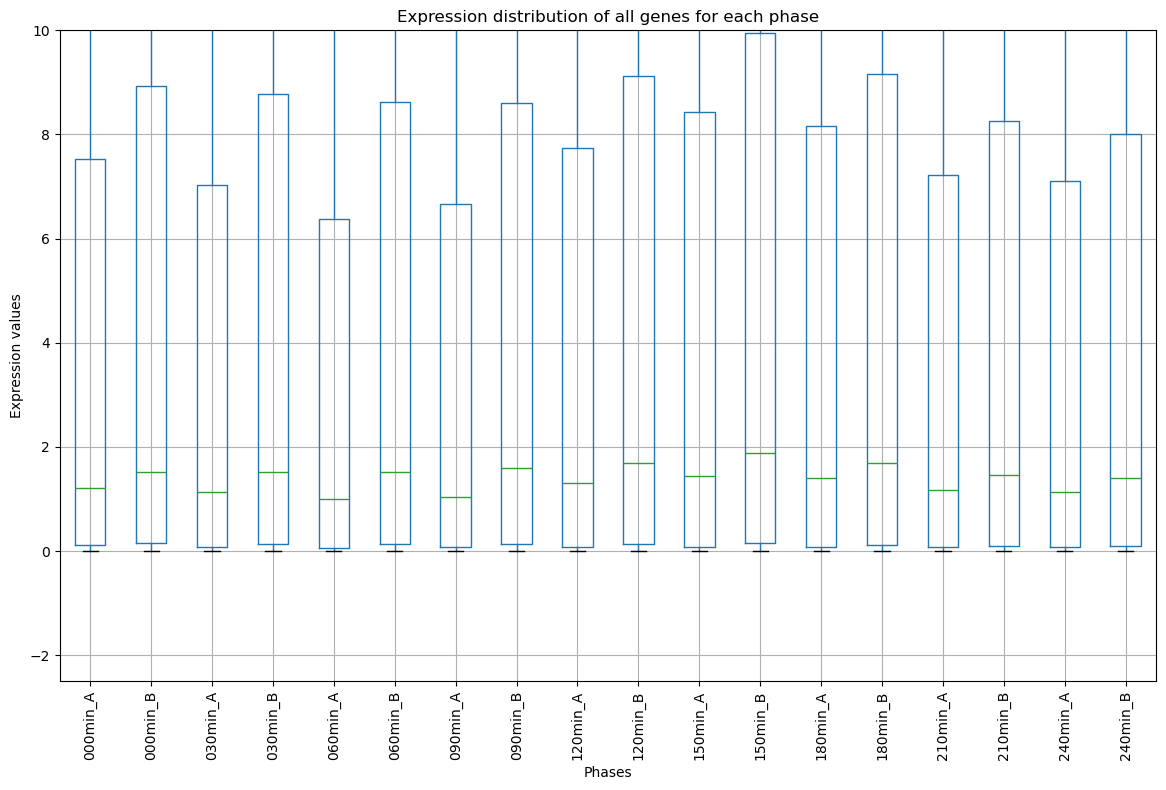

In [83]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

# Plot boxplot for each phase
plt.figure(figsize=(12, 8))
df_tpm_data.boxplot(rot=90)
plt.title('Expression distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.tight_layout()
plt.ylim(top=10)
plt.ylim(bottom=-2.5)
plt.show()


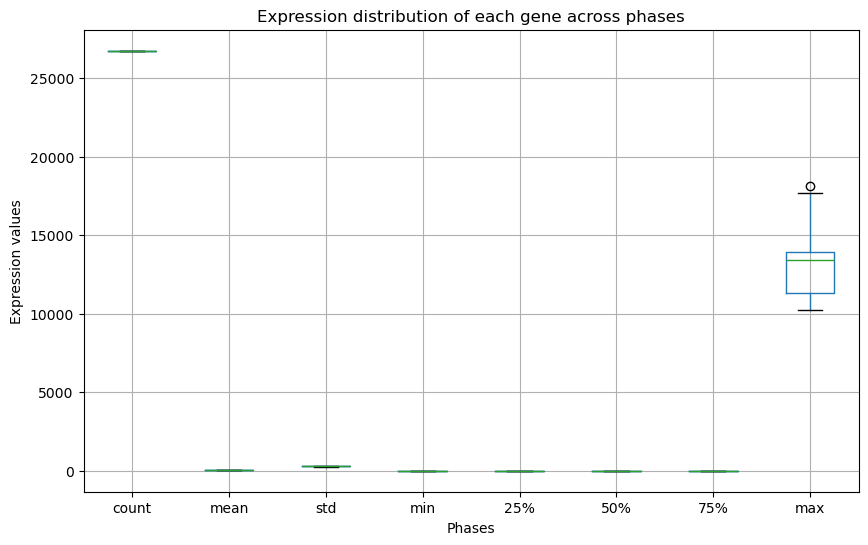

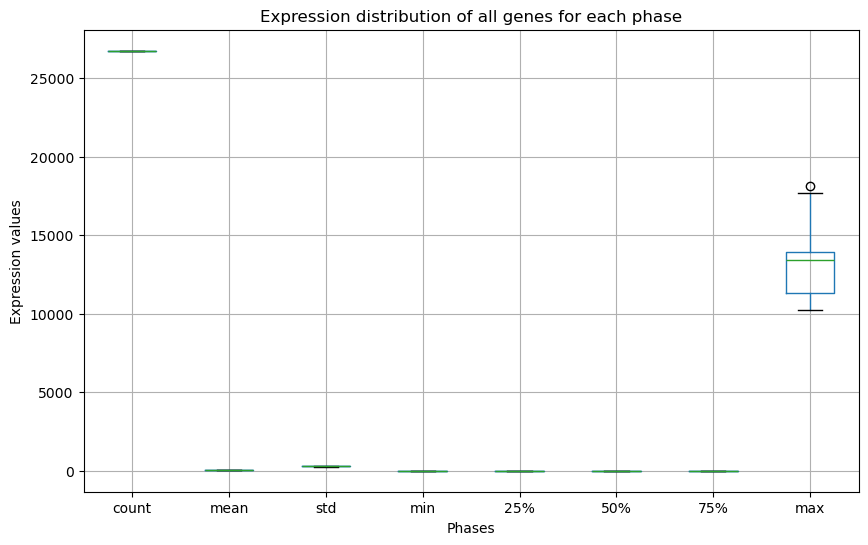

In [84]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

# Step 1: Phase-specific outliers
# Calculate expression distribution for each gene across phases
gene_expression_distribution = df_tpm_data.describe().T  # Transpose for easier processing

# Plot boxplots or histograms for each gene
plt.figure(figsize=(10, 6))
gene_expression_distribution.boxplot()
plt.title('Expression distribution of each gene across phases')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.show()

# Step 2: Gene-specific outliers
# Calculate expression distribution for each phase across genes
phase_expression_distribution = df_tpm_data.describe()

# Plot boxplots or histograms for each phase
plt.figure(figsize=(10, 6))
phase_expression_distribution.T.boxplot()
plt.title('Expression distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.show()

In [85]:
# # Identify genes with consistently low or high expression values across phases
# gene_outliers = []
# for gene in data.index:
#     if (data.loc[gene] < threshold).all() or (data.loc[gene] > threshold).all():
#         gene_outliers.append(gene)

# # Filter out genes with consistent outlier behavior
# filtered_data = data.drop(gene_outliers, axis=0)

# Filter out genes

In [86]:
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [87]:
df_no_all_zeros['max_tpm'] = df_no_all_zeros[tpm_cols].apply(lambda x: max(x), axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,...,0.350884,0.223363,0.467550,81.119158,49.775010,34.863348,65.968766,40.514722,27.276603,1.91038
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,...,0.885992,0.928159,0.856158,40.426648,32.172110,8.531957,17.994431,30.377400,17.552073,95.84080
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,...,0.655030,0.595625,0.955852,156.504684,137.772483,40.638336,55.643466,72.658777,9.946572,58.35270
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,...,0.588845,0.811844,0.733771,48.284261,44.607919,88.145834,21.842232,47.153096,25.979798,111.05500
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,...,0.788707,0.928039,0.929460,30.542646,61.488668,32.470534,27.107796,26.107030,1.018792,35.82090


In [88]:
TPM_THRESHOLD_PERCENTILE = 0

In [89]:
np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE)

5.7937e-11

In [90]:
st.percentileofscore(tpms_flattened[tpms_flattened != 0], np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE), kind='weak')

0.00023892921483081422

In [91]:
df_tpm_filtered = df_no_all_zeros.loc[df_no_all_zeros['max_tpm'] > np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE)]
df_no_all_zeros.shape, df_tpm_filtered.shape

((25534, 35), (25534, 35))

In [92]:
df_tpm_filtered.loc[df_tpm_filtered['TTHERM_ID'].isin(target_ttherms)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm
68,YF00000081.t1,0.136596,0.666185,0.263514,0.792566,0.254972,0.635053,0.227706,1.245530,0.149870,...,0.451593,0.797328,0.464615,60.546244,70.185539,118.177036,31.465913,1.732849,33.153569,1.609870
2097,YF00002595.t1,0.020342,0.000000,0.000000,0.000000,0.020755,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,200.000000,0.000000,200.000000,0.000000,0.000000,0.000000,0.020755
2644,YF00003349.t1,0.000000,0.000000,0.000000,0.059074,0.057344,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,200.000000,200.000000,0.059074
3396,YF00004316.t1,0.050007,0.132608,0.000000,0.040174,0.000000,0.064604,0.000000,0.036508,0.056887,...,0.000000,1.000000,1.000000,200.000000,200.000000,90.464321,0.000000,200.000000,200.000000,0.132608
4418,YF00005570.t1,0.054247,0.000000,0.000000,0.057249,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,200.000000,0.000000,200.000000,0.000000,200.000000,200.000000,0.057249
5923,YF00007477.t1,0.070869,0.000000,0.000000,0.037388,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,200.000000,0.000000,200.000000,0.000000,200.000000,200.000000,0.070869
6368,YF00008072.t1,0.000000,0.000000,0.000000,0.013220,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,200.000000,200.000000,0.013220
6379,YF00008085.t1,0.000000,0.000000,0.000000,0.000000,0.034595,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034595
6816,YF00008689.t1,0.000000,0.027653,0.000000,0.000000,0.059719,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,200.000000,200.000000,200.000000,0.000000,200.000000,0.059719
6873,YF00008765.t1,0.000000,0.000000,0.000000,0.060847,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,200.000000,200.000000,0.060847


In [93]:
diff_cols

['000min_diff',
 '030min_diff',
 '060min_diff',
 '090min_diff',
 '120min_diff',
 '150min_diff',
 '180min_diff',
 '210min_diff',
 '240min_diff']

In [94]:
df_no_all_zeros['min_diff'] = df_no_all_zeros[diff_cols].apply(lambda x: np.min(x[x != 0]) if len(x[x != 0]) > 0 else 0, axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,...,0.223363,0.467550,81.119158,49.775010,34.863348,65.968766,40.514722,27.276603,1.91038,0.223363
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,...,0.928159,0.856158,40.426648,32.172110,8.531957,17.994431,30.377400,17.552073,95.84080,0.569516
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,...,0.595625,0.955852,156.504684,137.772483,40.638336,55.643466,72.658777,9.946572,58.35270,0.394450
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,...,0.811844,0.733771,48.284261,44.607919,88.145834,21.842232,47.153096,25.979798,111.05500,0.315146
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,...,0.928039,0.929460,30.542646,61.488668,32.470534,27.107796,26.107030,1.018792,35.82090,0.648990


In [95]:
df_no_all_zeros_zero_min_diffs = df_no_all_zeros.loc[df_no_all_zeros['min_diff'] == 0].loc[:, ['TTHERM_ID']+diff_cols]
df_no_all_zeros_zero_min_diffs.shape

(9, 10)

In [96]:
df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID']=='YF00000043.t1'].loc[:, ['TTHERM_ID'] + diff_cols]

,TTHERM_ID,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
33,YF00000043.t1,0.943765,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


In [97]:
DIFF_THRESHOLD_PERCENTILE = 0

In [98]:
np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE)

3.610162523378034e-10

In [99]:
st.percentileofscore(diffs_flattened[diffs_flattened != 0], np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE), kind='weak')

0.0004636670499647613

In [100]:
df_diff_filtered = df_no_all_zeros.loc[df_no_all_zeros['min_diff'] > np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE)]
df_no_all_zeros.shape, df_diff_filtered.shape

((25534, 36), (25524, 36))

In [101]:
list(np.unique(max_tpm_ttherms))

['YF00003511.t1',
 'YF00003862.t1',
 'YF00016492.t1',
 'YF00017042.t1',
 'YF00023578.t1']

In [102]:
df_diff_filtered.loc[df_diff_filtered['TTHERM_ID'].isin(list(np.unique(max_tpm_ttherms)))]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
2772,YF00003511.t1,9266.42,6745.80,13592.40,7729.97,15019.400,7851.65,13783.000,7437.57,13832.000,...,0.951071,0.978664,34.193789,59.417103,26.573022,21.924887,31.993423,52.989078,15019.4,0.521063
3053,YF00003862.t1,4014.34,9277.61,4372.00,8286.43,4208.530,8820.12,5034.620,8962.44,5441.290,...,0.801187,0.820963,1.599755,61.183313,59.729714,1.817372,45.233749,43.505789,10965.9,0.432691
12414,YF00016492.t1,7283.36,12860.00,11305.80,18128.90,8015.920,17687.80,4101.120,14474.20,2555.930,...,0.721916,0.903666,54.913171,76.525986,24.149938,47.350550,80.525216,36.670170,18128.9,0.209139
12865,YF00017042.t1,7224.83,9407.72,7854.12,9098.39,7993.430,9187.04,8541.510,9059.84,8788.950,...,0.911353,0.913978,7.562890,9.544492,17.076566,2.427208,8.133870,5.709480,10599.3,0.767968
17870,YF00023578.t1,13954.10,3118.69,4745.34,2995.34,432.577,1392.58,217.535,1473.84,199.354,...,0.587363,0.921443,182.429657,96.299217,89.748447,116.686938,75.423433,37.384382,13954.1,0.147597


In [103]:
df_filtered = df_diff_filtered.merge(df_tpm_filtered, how='inner', on='TTHERM_ID')
print('# genes in df_tpm_filtered:', df_tpm_filtered.shape[0])
print('# genes in df_diff_filtered:', df_diff_filtered.shape[0])
print('# genes in df_filtered:', df_filtered.shape[0])

# genes in df_tpm_filtered: 25534
# genes in df_diff_filtered: 25524
# genes in df_filtered: 25524


In [104]:
df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID'].isin(list(np.unique(max_tpm_ttherms)))]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
2772,YF00003511.t1,9266.42,6745.80,13592.40,7729.97,15019.400,7851.65,13783.000,7437.57,13832.000,...,0.951071,0.978664,34.193789,59.417103,26.573022,21.924887,31.993423,52.989078,15019.4,0.521063
3053,YF00003862.t1,4014.34,9277.61,4372.00,8286.43,4208.530,8820.12,5034.620,8962.44,5441.290,...,0.801187,0.820963,1.599755,61.183313,59.729714,1.817372,45.233749,43.505789,10965.9,0.432691
12414,YF00016492.t1,7283.36,12860.00,11305.80,18128.90,8015.920,17687.80,4101.120,14474.20,2555.930,...,0.721916,0.903666,54.913171,76.525986,24.149938,47.350550,80.525216,36.670170,18128.9,0.209139
12865,YF00017042.t1,7224.83,9407.72,7854.12,9098.39,7993.430,9187.04,8541.510,9059.84,8788.950,...,0.911353,0.913978,7.562890,9.544492,17.076566,2.427208,8.133870,5.709480,10599.3,0.767968
17870,YF00023578.t1,13954.10,3118.69,4745.34,2995.34,432.577,1392.58,217.535,1473.84,199.354,...,0.587363,0.921443,182.429657,96.299217,89.748447,116.686938,75.423433,37.384382,13954.1,0.147597


In [105]:
df_filtered_diffs_flattened = df_diff_filtered.loc[:, diff_cols].to_numpy().flatten()

In [106]:
# plt.hist(df_filtered_diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.show()

# plt.hist(df_filtered_diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.ylim(top=200)

# plt.show()

# Export the filtered TPM data to CSV

# FILTER BY RAW COUNT SELECTION

In [107]:
df_no_all_zeros.shape, df_all_tpm.shape

((25534, 36), (26749, 19))

In [108]:
# df_filtered = df_no_all_zeros # FIXME
# df_filtered = df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID'].isin(complete_data_df_filtered['TTHERM_ID'].values)]

df_filtered = df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(df_all_cpm_filtered['TTHERM_ID'].values)]

In [109]:
df_filtered.shape

(23096, 19)

In [110]:
df_filtered.loc[df_filtered['TTHERM_ID'].isin(df_all_zeros['TTHERM_ID'].values)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [111]:
df_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,1.91038,0.519876,1.51815,0.662072,1.88687,0.23247,1.04077,0.449587,0.961581
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,66.35580,74.721600,63.78140,81.596900,72.29420,73.30320,78.97700,59.150900,69.088800
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,36.15000,19.308400,26.61180,15.117300,23.07880,12.54630,21.06410,18.884000,18.050300
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,92.39390,42.991100,111.05500,43.879800,74.51840,43.93570,54.11840,39.315500,53.580100
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,27.22590,32.557700,23.67660,35.820900,28.25220,32.40640,30.07440,27.039000,29.091100


In [112]:
df_filtered[tpm_cols].max(axis=None)

18128.9

In [113]:
df_filtered.loc[:, all_cols].to_csv('./tpm_kallisto.csv', index=False)

# Normalize expression per gene with zscore

In [114]:
# normalized_tpm_df = normalize_expression_per_gene(df_filtered)
normalized_tpm_df = df_filtered

Sanity check

In [115]:
row_to_check = normalized_tpm_df.loc[2, normalized_tpm_df.columns[1:]] 

row_mean = np.mean(row_to_check)
row_std = np.std(row_to_check)

print(row_mean)
print(row_std)

26.68887388888889
14.843069663093853


In [116]:
normalized_tpm_df.shape

(23096, 19)

In [117]:
normalized_tpm_df

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.549725,1.730460,0.892151,1.450130,0.374954,1.410570,0.611082,1.596680,1.100240,1.910380,0.519876,1.518150,0.662072,1.886870,0.232470,1.040770,0.449587,0.961581
1,YF00000003.t1,48.652000,57.089300,70.847100,50.868800,77.868100,53.966700,95.840800,54.582900,85.401500,66.355800,74.721600,63.781400,81.596900,72.294200,73.303200,78.977000,59.150900,69.088800
2,YF00000004.t1,1.530710,3.880620,33.442000,38.648700,58.352700,28.400600,55.139800,37.267500,32.926100,36.150000,19.308400,26.611800,15.117300,23.078800,12.546300,21.064100,18.884000,18.050300
3,YF00000005.t1,26.847200,85.189600,48.955700,86.638900,54.205700,91.765800,51.388500,85.331600,48.201800,92.393900,42.991100,111.055000,43.879800,74.518400,43.935700,54.118400,39.315500,53.580100
4,YF00000006.t1,23.819900,15.930500,20.584200,22.373200,34.599300,22.454600,34.389800,22.878900,33.823500,27.225900,32.557700,23.676600,35.820900,28.252200,32.406400,30.074400,27.039000,29.091100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26743,YF00038376.t1,0.024394,0.004626,0.000000,0.000000,0.000000,0.000000,0.005422,0.000000,0.000000,0.000000,0.000000,0.004925,0.000000,0.000000,0.000000,0.000000,0.000000,0.009277
26744,YF00038377.t1,1.022560,1.371080,1.453760,1.613210,3.066670,2.026740,2.837340,1.996630,1.878490,1.462970,1.570940,0.897557,1.518610,1.227130,1.541170,1.323590,1.669550,1.272710
26745,YF00038378.t1,0.480180,0.281865,0.110384,0.043421,0.055901,0.027933,0.060989,0.055898,0.065196,0.046846,0.067845,0.073870,0.074182,0.077418,0.079898,0.083517,0.056602,0.073917
26746,YF00038379.t1,2.252110,7.426000,3.490870,7.638870,2.527450,7.252890,2.509510,6.067370,3.008640,7.148050,3.173920,10.506500,3.446160,6.069360,2.657120,4.265530,2.505780,3.485930


# MEAN TYPE SELECTION

In [118]:
# df_filtered_averaged = ari_mean_df_of_duplicates(normalized_tpm_df.loc[:, all_cols])
# df_filtered_averaged = geo_mean_df_of_duplicates(df_filtered.loc[:, all_cols])
# df_filtered_averaged
df_filtered_averaged = df_filtered

In [119]:
df_filtered.loc[:, all_cols]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.549725,1.730460,0.892151,1.450130,0.374954,1.410570,0.611082,1.596680,1.100240,1.910380,0.519876,1.518150,0.662072,1.886870,0.232470,1.040770,0.449587,0.961581
1,YF00000003.t1,48.652000,57.089300,70.847100,50.868800,77.868100,53.966700,95.840800,54.582900,85.401500,66.355800,74.721600,63.781400,81.596900,72.294200,73.303200,78.977000,59.150900,69.088800
2,YF00000004.t1,1.530710,3.880620,33.442000,38.648700,58.352700,28.400600,55.139800,37.267500,32.926100,36.150000,19.308400,26.611800,15.117300,23.078800,12.546300,21.064100,18.884000,18.050300
3,YF00000005.t1,26.847200,85.189600,48.955700,86.638900,54.205700,91.765800,51.388500,85.331600,48.201800,92.393900,42.991100,111.055000,43.879800,74.518400,43.935700,54.118400,39.315500,53.580100
4,YF00000006.t1,23.819900,15.930500,20.584200,22.373200,34.599300,22.454600,34.389800,22.878900,33.823500,27.225900,32.557700,23.676600,35.820900,28.252200,32.406400,30.074400,27.039000,29.091100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26743,YF00038376.t1,0.024394,0.004626,0.000000,0.000000,0.000000,0.000000,0.005422,0.000000,0.000000,0.000000,0.000000,0.004925,0.000000,0.000000,0.000000,0.000000,0.000000,0.009277
26744,YF00038377.t1,1.022560,1.371080,1.453760,1.613210,3.066670,2.026740,2.837340,1.996630,1.878490,1.462970,1.570940,0.897557,1.518610,1.227130,1.541170,1.323590,1.669550,1.272710
26745,YF00038378.t1,0.480180,0.281865,0.110384,0.043421,0.055901,0.027933,0.060989,0.055898,0.065196,0.046846,0.067845,0.073870,0.074182,0.077418,0.079898,0.083517,0.056602,0.073917
26746,YF00038379.t1,2.252110,7.426000,3.490870,7.638870,2.527450,7.252890,2.509510,6.067370,3.008640,7.148050,3.173920,10.506500,3.446160,6.069360,2.657120,4.265530,2.505780,3.485930


# Filter out genes with all zeros

In [120]:
df_filtered_averaged_with_all_zeros = df_filtered_averaged[(df_filtered_averaged.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_averaged_with_all_zeros.shape)

df_filtered_averaged_with_all_zeros.head()

(0, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [121]:
df_filtered_averaged_no_all_zeros = df_filtered_averaged[~df_filtered_averaged.isin(df_filtered_averaged_with_all_zeros)].dropna()
df_filtered_averaged_no_all_zeros.reset_index()
print(df_filtered_averaged.shape[0])
print(df_filtered_averaged_no_all_zeros.shape[0])
print(df_filtered_averaged.shape[0]-df_filtered_averaged_no_all_zeros.shape[0])
df_filtered_averaged_no_all_zeros.head()

23096
23096
0


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.549725,1.73046,0.892151,1.45013,0.374954,1.41057,0.611082,1.59668,1.10024,1.91038,0.519876,1.51815,0.662072,1.88687,0.23247,1.04077,0.449587,0.961581
1,YF00000003.t1,48.652000,57.08930,70.847100,50.86880,77.868100,53.96670,95.840800,54.58290,85.40150,66.35580,74.721600,63.78140,81.596900,72.29420,73.30320,78.97700,59.150900,69.088800
2,YF00000004.t1,1.530710,3.88062,33.442000,38.64870,58.352700,28.40060,55.139800,37.26750,32.92610,36.15000,19.308400,26.61180,15.117300,23.07880,12.54630,21.06410,18.884000,18.050300
3,YF00000005.t1,26.847200,85.18960,48.955700,86.63890,54.205700,91.76580,51.388500,85.33160,48.20180,92.39390,42.991100,111.05500,43.879800,74.51840,43.93570,54.11840,39.315500,53.580100
4,YF00000006.t1,23.819900,15.93050,20.584200,22.37320,34.599300,22.45460,34.389800,22.87890,33.82350,27.22590,32.557700,23.67660,35.820900,28.25220,32.40640,30.07440,27.039000,29.091100


In [122]:
df_filtered_averaged_no_all_zeros[df_filtered_averaged_no_all_zeros['TTHERM_ID'].isin(satellite_ttherm_ids)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
68,YF00000081.t1,0.136596,0.666185,0.263514,0.792566,0.254972,0.635053,0.227706,1.245530,0.149870,1.039410,0.181974,1.609870,0.325479,0.720735,0.255207,0.320078,0.361912,0.778950
558,YF00000703.t1,0.235943,0.472866,0.243525,0.428566,0.219293,0.540871,0.256490,0.240052,0.136652,0.348013,0.173088,0.347640,0.080316,0.251132,0.369970,0.423302,0.285949,0.238693
2360,YF00002942.t1,0.000000,0.025652,0.078912,0.000000,0.027686,0.047548,0.180821,0.000000,0.100954,0.050364,0.030850,0.054581,0.000000,0.000000,0.034160,0.027789,0.048188,0.000000
2430,YF00003060.t1,0.045074,0.000000,0.008712,0.038043,0.009187,0.000000,0.010019,0.009189,0.000000,0.008391,0.000000,0.000000,0.008611,0.000000,0.011271,0.000000,0.007978,0.000000
2641,YF00003345.t1,0.108305,0.256151,0.105066,0.171415,0.138235,0.142439,0.030094,0.304462,0.029620,0.226318,0.092418,0.163510,0.000000,0.027089,0.034111,0.027749,0.000000,0.103162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26445,YF00037875.t1,0.012705,0.060188,0.024576,0.053619,0.012953,0.055530,0.000000,0.103667,0.083526,0.059102,0.028968,0.166567,0.012148,0.012674,0.000000,0.038813,0.011253,0.060440
26483,YF00037943.t1,0.050877,0.055119,0.021064,0.030672,0.029623,0.012691,0.040387,0.037032,0.043353,0.033831,0.049748,0.022005,0.073259,0.021725,0.054482,0.014766,0.025718,0.034559
26546,YF00038060.t1,253.981000,244.752000,229.462000,252.136000,212.880000,245.373000,179.050000,223.328000,169.695000,212.851000,152.904000,192.583000,138.814000,187.403000,152.378000,184.092000,163.463000,187.370000
26621,YF00038176.t1,0.046154,0.034037,0.074278,0.010820,0.031345,0.022376,0.005699,0.010448,0.011247,0.052528,0.023408,0.046592,0.034258,0.020429,0.051209,0.031226,0.009069,0.024380


# SATELLITE GENE TPMS

In [123]:
(df_no_all_zeros[df_no_all_zeros['TTHERM_ID'].isin(satellite_ttherm_ids)])[all_cols]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
68,YF00000081.t1,0.136596,0.666185,0.263514,0.792566,0.254972,0.635053,0.227706,1.245530,0.149870,1.039410,0.181974,1.609870,0.325479,0.720735,0.255207,0.320078,0.361912,0.77895
169,YF00000208.t1,0.000000,0.041714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
181,YF00000224.t1,0.000000,0.050334,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047656,0.00000
217,YF00000266.t1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
293,YF00000364.t1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041781,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26546,YF00038060.t1,253.981000,244.752000,229.462000,252.136000,212.880000,245.373000,179.050000,223.328000,169.695000,212.851000,152.904000,192.583000,138.814000,187.403000,152.378000,184.092000,163.463000,187.37000
26561,YF00038078.t1,0.006230,0.005906,0.000000,0.000000,0.006347,0.000000,0.000000,0.000000,0.006830,0.005800,0.000000,0.018864,0.005947,0.006206,0.000000,0.000000,0.000000,0.00000
26607,YF00038144.t1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
26621,YF00038176.t1,0.046154,0.034037,0.074278,0.010820,0.031345,0.022376,0.005699,0.010448,0.011247,0.052528,0.023408,0.046592,0.034258,0.020429,0.051209,0.031226,0.009069,0.02438


In [124]:
df_filtered_averaged_no_all_zeros

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,YF00000001.t1,0.549725,1.730460,0.892151,1.450130,0.374954,1.410570,0.611082,1.596680,1.100240,1.910380,0.519876,1.518150,0.662072,1.886870,0.232470,1.040770,0.449587,0.961581
1,YF00000003.t1,48.652000,57.089300,70.847100,50.868800,77.868100,53.966700,95.840800,54.582900,85.401500,66.355800,74.721600,63.781400,81.596900,72.294200,73.303200,78.977000,59.150900,69.088800
2,YF00000004.t1,1.530710,3.880620,33.442000,38.648700,58.352700,28.400600,55.139800,37.267500,32.926100,36.150000,19.308400,26.611800,15.117300,23.078800,12.546300,21.064100,18.884000,18.050300
3,YF00000005.t1,26.847200,85.189600,48.955700,86.638900,54.205700,91.765800,51.388500,85.331600,48.201800,92.393900,42.991100,111.055000,43.879800,74.518400,43.935700,54.118400,39.315500,53.580100
4,YF00000006.t1,23.819900,15.930500,20.584200,22.373200,34.599300,22.454600,34.389800,22.878900,33.823500,27.225900,32.557700,23.676600,35.820900,28.252200,32.406400,30.074400,27.039000,29.091100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26743,YF00038376.t1,0.024394,0.004626,0.000000,0.000000,0.000000,0.000000,0.005422,0.000000,0.000000,0.000000,0.000000,0.004925,0.000000,0.000000,0.000000,0.000000,0.000000,0.009277
26744,YF00038377.t1,1.022560,1.371080,1.453760,1.613210,3.066670,2.026740,2.837340,1.996630,1.878490,1.462970,1.570940,0.897557,1.518610,1.227130,1.541170,1.323590,1.669550,1.272710
26745,YF00038378.t1,0.480180,0.281865,0.110384,0.043421,0.055901,0.027933,0.060989,0.055898,0.065196,0.046846,0.067845,0.073870,0.074182,0.077418,0.079898,0.083517,0.056602,0.073917
26746,YF00038379.t1,2.252110,7.426000,3.490870,7.638870,2.527450,7.252890,2.509510,6.067370,3.008640,7.148050,3.173920,10.506500,3.446160,6.069360,2.657120,4.265530,2.505780,3.485930


In [125]:
df_filtered_averaged_no_all_zeros[df_filtered_averaged_no_all_zeros.isna().any(axis=1)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [126]:
df_filtered_averaged_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
19659,YF00025823.t1,0.841968,0.792971,0.249350,0.450057,0.320230,0.406612,0.243289,0.428881,0.233883,0.318817,0.249787,0.351292,0.294654,0.374587,0.413465,0.410228,0.416942,0.442995
10203,YF00013410.t1,0.852229,0.865904,0.629786,0.752018,0.553078,0.880908,0.464973,1.027680,0.729803,1.196090,0.670980,0.843480,0.533708,0.912448,0.641052,0.458146,0.645434,0.840488
9665,YF00012715.t1,0.730953,0.843264,0.901208,1.564700,0.863833,1.314300,1.047830,1.836130,1.973630,2.237760,2.246820,2.201330,1.548860,1.985730,0.954253,1.627330,0.862796,1.189090
10660,YF00014043.t1,63.172300,46.546600,49.064000,42.508300,29.495100,32.216600,27.270500,30.800900,30.675400,33.282400,37.742700,35.119300,46.222500,40.703900,52.561900,46.467900,48.183800,48.376500
12916,YF00017103.t1,15.631200,23.696700,19.814100,28.569600,17.209800,23.215400,14.645400,19.418700,11.141900,14.922500,12.077000,22.617100,12.390100,13.703700,14.480300,13.467900,17.459600,14.284500
13407,YF00017742.t1,3.143780,3.944450,1.600360,3.812620,1.813940,3.969740,2.370610,4.268520,3.221570,3.851810,3.701040,3.890980,3.213860,3.693390,3.565870,3.925220,4.640540,3.972770
17179,YF00022696.t1,0.682201,0.916931,0.095404,0.308012,0.000000,0.344905,0.000000,0.502060,0.211697,0.089699,0.219256,0.097279,0.094504,0.393288,0.371494,0.607483,0.000000,0.093377
16080,YF00021208.t1,7.349340,7.338110,10.105500,11.965100,6.526240,8.150730,4.805490,7.608730,5.912610,6.978180,6.773100,6.793010,8.674550,7.841060,9.220470,9.023910,9.725350,9.201130
14226,YF00018813.t1,0.371354,0.188471,0.179599,0.167912,0.148746,0.266669,0.206360,0.229973,0.247018,0.296107,0.090707,0.227352,0.177552,0.198464,0.066446,0.148593,0.152727,0.264993
7688,YF00009881.t1,0.354713,1.028780,0.519577,0.873209,0.317737,0.460191,0.274760,0.482215,0.435846,0.480114,0.367697,0.737294,0.410886,0.610905,0.390014,0.503047,0.390160,0.582821


In [127]:
df_filtered_averaged_no_all_zeros.to_csv('./kallisto.csv', index=False)